# Diffusivity from Zahn estimate and from FV time evolution

Works with jupyterlab3 on ppmstar.org

In [1]:
%pylab ipympl
import os,sys
from multiprocessing import Pool
from tqdm import tqdm

sys.path.insert(0,'/home/user/user/niagara_scratch_sblouin/PyPPM')
from ppmpy import ppm

# set cycling combination of color-blind labels, glyphs, styles
lll= 2*['-', '--', ':', '-.']
markers = ['X','h','<','>','s','^','d','X','p']
random.shuffle(lll)
CB_color_cycle = ['#4daf4a', '#a65628', '#984ea3',
                  '#ff7f00', '#f781bf', '#377eb8',
                  '#999999', '#e41a1c', '#dede00']
rc('axes', prop_cycle=(cycler('color', CB_color_cycle[0:8]) +cycler('linestyle',lll)))

import collections
hydro = collections.namedtuple('hydro', ['moms','rprof'])

# turn off matplotlib messages
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

from nugridpy import mesa as ms
from nugridpy import utils as ut
import scipy
from scipy.optimize import curve_fit

# astronomical and physical constants in SI and sgs units
from astropy import constants as const
from astropy import units as u

Msun = (const.M_sun).value
Rsun = (const.R_sun).value
Lsun = (const.L_sun).value
GN = (const.G).value  # Newton's constant 
sigma = (const.sigma_sb).value  # 1e3 tarnsforms SI units to sgs units

# transform to cgs units
GN = 1e3*GN
sigma = 1e3*sigma
Rsun = 1e2*Rsun
Msun = 1e3*Msun
Lsun = 1e7*Lsun

Populating the interactive namespace from numpy and matplotlib


## (1) Important parameter definitions

In [2]:
# the list of variables that are stored within the momsdata cube.
var_list = ['xc','ux','uy','uz','|ut|','|ur|','|w|','T','rho','fv']

In [3]:
# data_dir = '/home/user/user/frontera_scratch3_mao1/'
data_dir = '/home/user/user/niagara_scratch_sblouin/'
runs = ['X30']
heating = np.array([1])
dumps = [[700]]
scaling_exponent = 1/4 # alpha in vorticity \propto L^alpha
plot_labels = ['tip']
run_dir = ['X30']

## (2) Load PPMstar r profiles

In [4]:
rprof = {}
rprofbq = {}
for i,run in enumerate(runs):
    rprof_dir = os.path.join(data_dir,run_dir[i],'prfs')
    rprof[run] = ppm.RprofSet(rprof_dir)
    rprofbq[run] = ppm.RprofSet(rprof_dir, bqav=True, var_list=var_list)

701 rprof files found in '/home/user/user/niagara_scratch_sblouin/X30/prfs/.
Dump numbers range from 0 to 700.
1 rprof files found in '/home/user/user/niagara_scratch_sblouin/X30/prfs/frombqavs/.
Dump numbers range from 700 to 700.


In [35]:
cvz_position = []
radius = {}
vorticity = {}
Ur_rms = {}
R_prfs = {}
U_rms = {}
for i,run in enumerate(runs):
    for j,dump in enumerate(dumps[i]):
        w_momst, r_moms = rprofbq[run].get('|w|',dump), rprofbq[run].get('xcmax',dump)
        ur, r_prfs = rprof[run].get('|Ur|',dump), rprof[run].get('R',dump)
        u = rprof[run].get('|U|',dump)
        if j==0:
            w_moms = w_momst
            Ur = ur
            U = u
        else:
            w_moms += w_momst
            Ur += ur
            U += u
    w_moms = w_moms/len(dumps[i])
    Ur = Ur/len(dumps[i])
    U = U/len(dumps[i])
    radius[run] = r_moms[r_moms>0]
    vorticity[run] = w_moms[r_moms>0]
    Ur_rms[run] = Ur
    U_rms[run] = U
    R_prfs[run] = r_prfs

In [36]:
N2 = {}
K = {}
for i,run in enumerate(runs):
    dump = int(mean(dumps[i]))
    R = rprof[run].get('R',dump)
    N2_full_res = rprof[run].compute_N2(dump)
    N2_inter = interp(radius[run], R[::-1], N2_full_res[::-1])
    N2[run] = N2_inter#/((pi*2)**2)
    K_full_res = rprof[run].compute_Drad(dump)
    K[run] = interp(radius[run], R[::-1], K_full_res[::-1])/heating[i]

## (3) Verifications

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'N ($\\mu$Hz)')

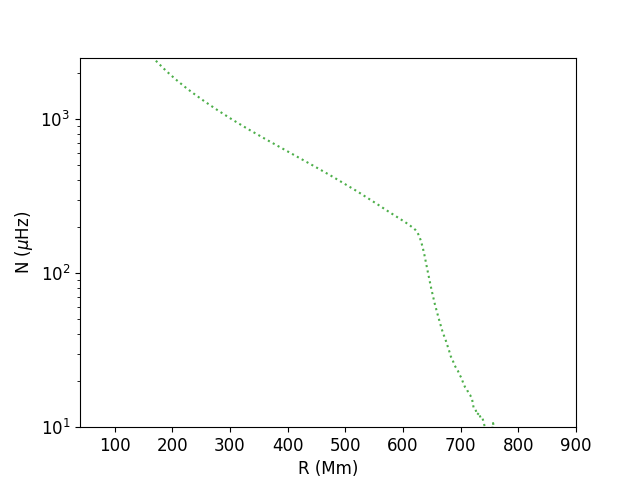

In [37]:
close(1);figure(1)
for i,run in enumerate(runs):
    semilogy(radius[run], sqrt(N2[run])*1e6)
xlim(40,900)
ylim(10,2500)
xlabel('R (Mm)')
ylabel('N ($\mu$Hz)')

(200.0, 800.0)

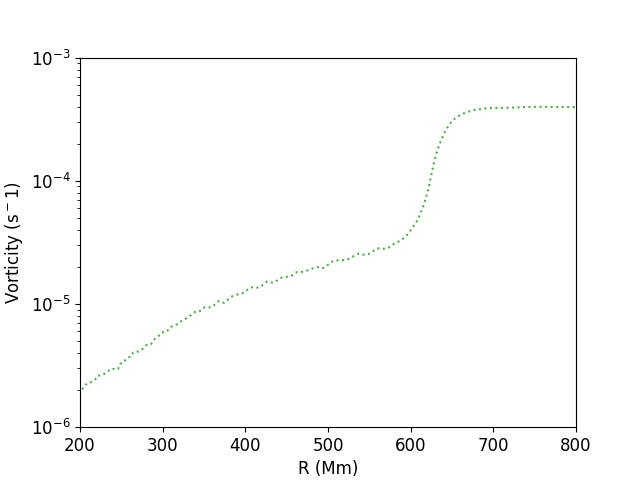

In [38]:
close(2);figure(2)
for i,run in enumerate(runs):
    semilogy(radius[run], vorticity[run])
xlim(40,900)
ylim(1e-6,1e-3)
xlabel('R (Mm)')
ylabel('Vorticity (s$^-1$)')
xlim(200,800)

(200.0, 800.0)

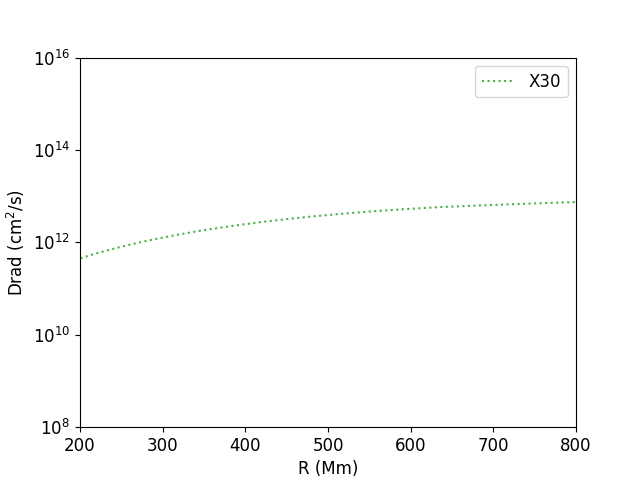

In [39]:
close(3);figure(3)
for i,run in enumerate(runs):
    semilogy(radius[run], K[run],label=run)
legend()
xlim(40,900)
ylim(1e8,1e16)
xlabel('R (Mm)')
ylabel('Drad (cm$^2$/s)')
xlim(200,800)

## (4) FV inversion

In [40]:
def diffusion_analysis(rp,delta_range,fraction,runid,min_max_range,rlim,Dlims,fit_rlim=True,\
                       varlim=(1.e-5,1.5),var='Xcld',sparse=1,ifig0=1):
    dumpc = np.diff(np.array(min_max_range))[0]//2 + min_max_range[0]
    range1 = list(range(min_max_range[0],dumpc - delta_range//2,sparse))
    range2 = list(range(dumpc + delta_range//2,min_max_range[1],sparse))
    print("central dump, and range1 and 2: ",dumpc,range1,range2)
    Hp = rp.compute_Hp(fname=dumpc)
    Rr = rp.get('R',fname=dumpc)
    cb = rp.bound_rad(dumpc,200,800,var='ut',criterion='max_grad')
    hpbnds = Hp[np.where(Rr>cb)][-1]
    print('Convective boundary: {:.3f}Mm'.format(cb[0]))
    print('Pressure scale height at convective boundary: {:.3f}Mm'.format(hpbnds))
    
    if not fit_rlim == None:
        fit_rlim=[cb,cb+fraction*hpbnds]; print(fit_rlim)
            
    res=rp.DsolveLgr(range1,range2,integrate_upwards=False,rlim=rlim,fit_rlim=fit_rlim,\
                  run_id=runid,logvar=True,Dlim=Dlims,varlim=varlim,var=var,ifig0=ifig0)

    if not fit_rlim == None:
        return dumpc,res['f_CBM'],res['D']
    else:
        return dumpc,res['D']

central dump, and range1 and 2:  650 [600, 610, 620, 630, 640] [650, 660, 670, 680, 690]
Convective boundary: 635.878Mm
Pressure scale height at convective boundary: 235.940Mm
Dump 0 at t = 0.00 min is the closest to t = 0.00 min.
Dump 0 at t = 0.00 min is the closest to t = 0.00 min.
Dump 0 at t = 0.00 min is the closest to t = 0.00 min.
Dump 0 at t = 0.00 min is the closest to t = 0.00 min.
Dump 0 at t = 0.00 min is the closest to t = 0.00 min.
Dump 0 at t = 0.00 min is the closest to t = 0.00 min.
Dump 0 at t = 0.00 min is the closest to t = 0.00 min.
Dump 0 at t = 0.00 min is the closest to t = 0.00 min.


/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


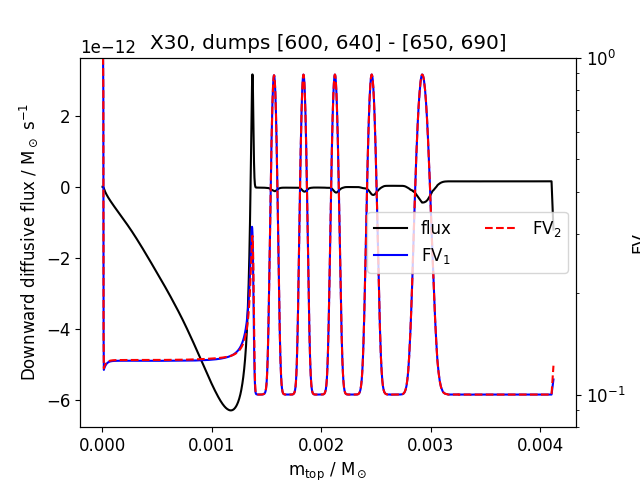

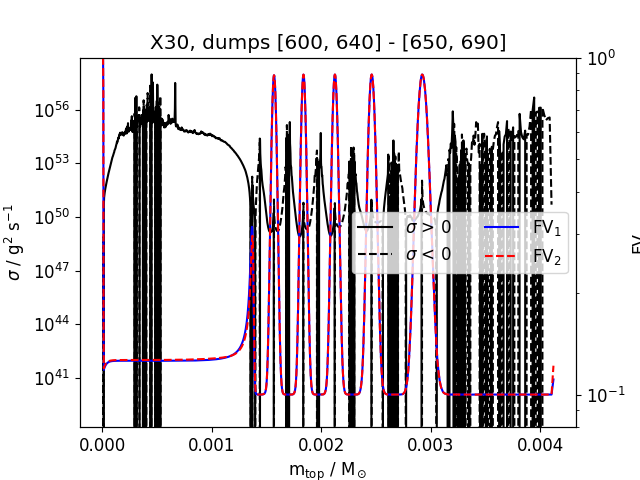

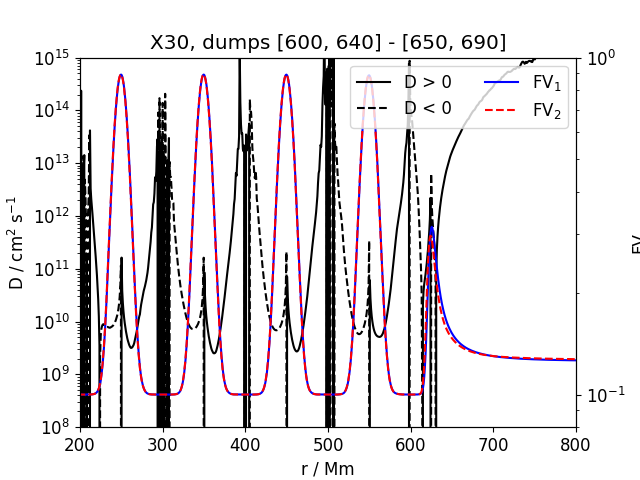

In [41]:
min_dump, end_dump = 600, 700
delta_dump = end_dump - min_dump
min_max_range = [min_dump, min_dump+delta_dump]   # this is considered the useable range
delta_range   = 0  # number of dumps between upper limit of low range 
sparse=10
rp = rprof['X30']
fraction = 0.2
case = run
r_min_plot, r_max_plot = 200, 800
Dlims = (1.e8,1.e15)
dumpc,DFV = diffusion_analysis(rp,delta_range,fraction,case,\
                 min_max_range,(r_min_plot,r_max_plot),Dlims,fit_rlim=None,
                               varlim=(8e-2,1.),var='FV', sparse=sparse,ifig0=20+i)
r_DFV = rp.get('R',int(0.5*min_dump+0.5*end_dump))

## (5) Figure

In [42]:
def doublef(z,f1,f2,z2):
    global Hp,D0
    D2 = D0*exp(-2*z2/f1/Hp)
    Dcbm = D2*exp(-2*(z-z2)/f2/Hp)
    D1 = D0*exp(-2*z/f1/Hp)
    D = D1
    D[z>z2] = Dcbm[z>z2]
    return log10(D)

In [43]:
matplotlib.rcParams.update({'font.size': 12})

      f1    f2    D0    D2
tip   0.058 0.340 11.96 10.22


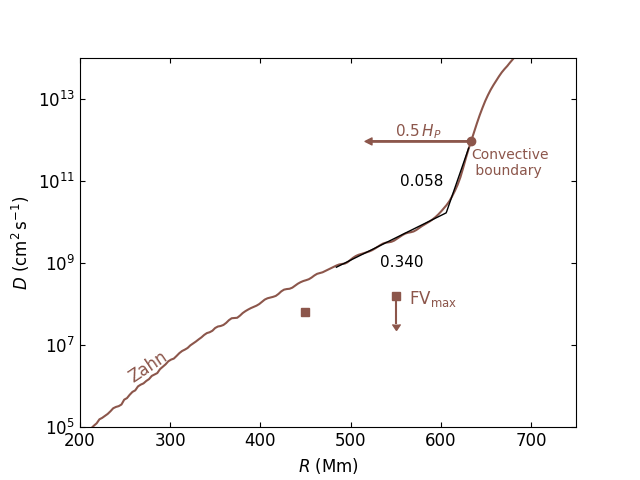

In [15]:
close(111);figure(111)

minxshow = [450,600]
maxxshow = [690,800]

angle = [22,29]

colors = ['tab:brown', 'tab:brown']

eta = 0.1

print('      f1    f2    D0    D2')
for i,run in enumerate(runs):
    # diffusivity from Zahn formula
    vorticity_nominal = (1/heating[i])**(scaling_exponent) * vorticity[run]
    ans = eta*K[run]*vorticity_nominal**2/N2[run]
    semilogy(radius[run], ans, ls='-', color=colors[i])
    rlabel = 250
    text(rlabel,2*interp(rlabel,radius[run][::-1],ans[::-1]),'Zahn',
         rotation=34,va='bottom',color=colors[i],fontsize=12)

    # add CB
    cp = rprof[run].bound_rad(cycles=dumps[i],r_min=200,r_max=800,var='|Ut|',criterion='max_grad') 
    cp = mean(cp)
    cpy = np.interp(cp,radius[run][::-1],ans[::-1])
    plot(cp, cpy, 'o', color=colors[i])
    
    # add Hp
    radius2 = rprof[run].get('R',int(np.mean(dumps[i])))
    Hpv = rprof[run].compute_Hp(int(np.mean(dumps[i])))
    Hp = interp(cp, radius2[::-1], Hpv[::-1])
    annotate('', xy=(cp-Hp*0.5, cpy), xytext=(cp, cpy), 
            arrowprops=dict(facecolor=colors[i], 
                            edgecolor=colors[i], width=1, headwidth=5, headlength=5),)
    if i==0:
        text(cp,cpy*.7,'Convective\n boundary',va='top',color=colors[i],size=10)
    if i==0:
        text((2*cp-0.5*Hp)/2,cpy,r'$0.5\,H_P$',va='bottom',color=colors[i],size=11, ha='center')
    
    # fit f1 and f2
    dx = 150
    mask = (radius[run]<cp)&(radius[run]>cp-dx)
    x = radius[run][mask]
    z = cp-radius[run][mask]
    y = ans[mask]
    D0 = interp(cp, radius[run][::-1], ans[::-1])
    popt, pcov = curve_fit(doublef, z, log10(y), p0=[0.1,0.5,50])
    xplot = np.linspace(min(x),max(x),500)
    zplot = cp-xplot
    if i==1:
        plot(xplot, 10**doublef(zplot,popt[0],popt[1],popt[2]),'-k',linewidth=1,label='double-$f$ fit')
        text(.91*xplot[-1], .2*10**doublef(zplot,popt[0],popt[1],popt[2])[-1],"{:.3f}".format(popt[0]),
            fontsize=11)
        text(1.03*xplot[0], 5*10**doublef(zplot,popt[0],popt[1],popt[2])[0],"{:.3f}".format(popt[1]),
            fontsize=11)
    else:
        plot(xplot, 10**doublef(zplot,popt[0],popt[1],popt[2]),'-k',linewidth=1)
        text(0.88*xplot[-1], 0.12*10**doublef(zplot,popt[0],popt[1],popt[2])[-1],"{:.3f}".format(popt[0]),
            fontsize=11)
        text(1.1*xplot[0], 10**doublef(zplot,popt[0],popt[1],popt[2])[0],"{:.3f}".format(popt[1]),
            fontsize=11)
    f1,f2,z2 = popt
    D2 = D0*exp(-2*z2/f1/Hp)
    print(plot_labels[i].ljust(5)+' '+"{:.3f}".format(f1)+' '+"{:.3f}".format(f2)+
          ' '+"{:.2f}".format(log10(D0)).rjust(5)+' '+"{:.2f}".format(log10(D2)).rjust(5))
    
xlabel(r'$R$ (Mm)')
ylabel(r'$D$ (cm$^2\,$s$^{-1}$)')
ax = plt.gca()
ax.tick_params(axis='both',direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
xlim(200,750)
ylim(1e5,1e14)
#legend(frameon=False)

# add Texascale results
#plot([450],[10**8.1],'s',color=colors[1])

y = array([10**7.80, 10**8.2])
hiy = array([10**7.75, 10**8.2]) 
errorbar([550], [10**8.2], yerr=0.8*10**8.2, uplims=0.8*10**8.2, marker='s', color=colors[1], ls='None')
errorbar([450], [10**7.8], yerr=10**6.88, marker='s', color=colors[1], ls='None')
text(565,10**8.,r'${\rm FV}_{\rm max}$',color=colors[1])

#title('X30 Texascale')

savefig('Dzahn_X30.pdf', bbox_inches='tight')

In [44]:
from scipy.optimize import curve_fit
def alpha_model(dr, a, b):
    return a*dr + b

      f1    f2    D0    D2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 0, 'R (Mm)')

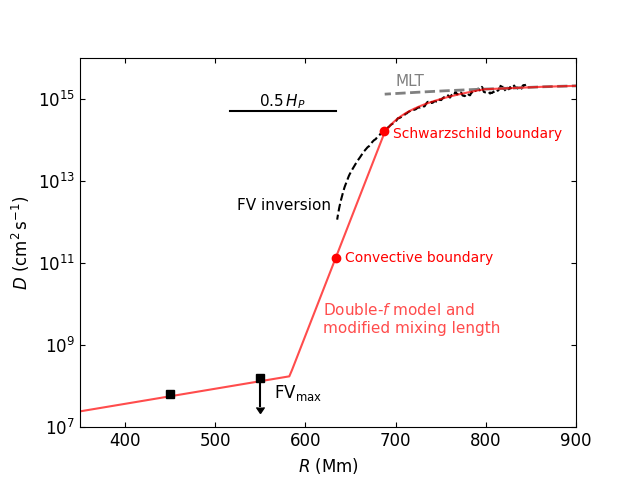

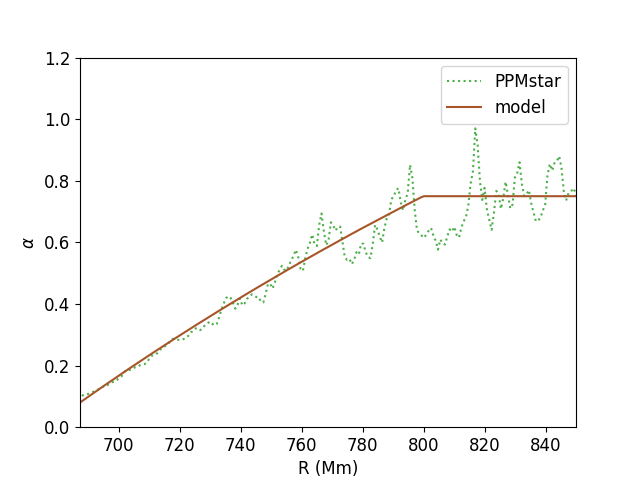

In [45]:
close(112);figure(112)

minxshow = [450,600]
maxxshow = [690,800]

angle = [22,29]

colors = ['tab:brown', 'tab:brown']

eta = 0.01

print('      f1    f2    D0    D2')
for i,run in enumerate(runs):
    # diffusivity from Zahn formula
    vorticity_nominal = (1/heating[i])**(scaling_exponent) * vorticity[run]
    ans = eta*K[run]*vorticity_nominal**2/N2[run]
    
    # add FV inversion
    semilogy(r_DFV[(r_DFV>635)&(r_DFV<845)], DFV[(r_DFV>635)&(r_DFV<845)], '--', color='k')
        
    cp = rprof[run].bound_rad(cycles=dumps[i],r_min=200,r_max=800,var='|Ut|',criterion='max_grad') 
    cp = mean(cp)

    # add SB
    sb = rprof[run].schwarzschild_bound(cycles=dumps[i], rmin=400, rmax=1000)
    sb = mean(sb)
    sby = np.interp(sb,r_DFV[::-1],DFV[::-1])
    plot(sb, sby, 'or')
    
    # add Hp
    radius2 = rprof[run].get('R',int(np.mean(dumps[i])))
    Hpv = rprof[run].compute_Hp(int(np.mean(dumps[i])))
    Hp = interp(cp, radius2[::-1], Hpv[::-1])
    # annotate('', xy=(cp-Hp*0.5, cpy), xytext=(cp, cpy), 
    #         arrowprops=dict(facecolor='k', 
    #                         edgecolor='k', width=1, headwidth=5, headlength=5),)
    plot([cp,cp-0.5*Hp],[.5e15,.5e15],'-k')
    if i==0:
        text(cp+10,2e11,'Convective boundary',va='top',color='r',size=10)
        text(sb+10,2e14,'Schwarzschild boundary',va='top',color='r',size=10)
    if i==0:
        text((2*cp-0.5*Hp)/2,.5e15,r'$0.5\,H_P$',va='bottom',color='k',size=11, ha='center')
    
    # add MLT
    alpha_deep = 0.75
    plot(R_prfs[run][R_prfs[run]>sb], (1./3.)*U_rms[run][R_prfs[run]>sb]*Hpv[R_prfs[run]>sb]*1e16*alpha_deep,
        color='grey',ls='--',lw=2)
    
    # modified MLT
    alpha = minimum(alpha_deep, exp(1*((R_prfs[run]-sb)/Hpv-1)))
    dr = (R_prfs[run]-sb)/Hpv
    alpha = minimum(alpha_deep, alpha_model(dr, 1.8, 0.08))
    model = (1./3.)*U_rms[run][R_prfs[run]>sb]*alpha[R_prfs[run]>sb]*1e16*Hpv[R_prfs[run]>sb]
    plot(R_prfs[run][R_prfs[run]>sb], model,'-r',alpha=0.7)
    
    # double f
    Hp = interp(sb, radius2[::-1], Hpv[::-1])
    dx = 500
    mask = (radius[run]<sb)&(radius[run]>sb-dx)
    x = radius[run][mask]
    z = sb-radius[run][mask]
    D0 = model[-1]
    dfmod = 10**doublef(z,0.06,0.92,105)
    plot(radius[run][mask],dfmod,'-r',alpha=0.7)

    # add CB
    cp = rprof[run].bound_rad(cycles=dumps[i],r_min=200,r_max=800,var='|Ut|',criterion='max_grad') 
    cp = mean(cp)
    cpy = np.interp(cp,radius[run][mask][::-1],dfmod[::-1])
    plot(cp, cpy, 'or')
    
xlabel(r'$R$ (Mm)')
ylabel(r'$D$ (cm$^2\,$s$^{-1}$)')
ax = plt.gca()
ax.tick_params(axis='both',direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
xlim(350,900)
ylim(1e7,1e16)
# xlim(600,900)
# ylim(1e13,1e16)

y = array([10**7.80, 10**8.2])
hiy = array([10**7.75, 10**8.2]) 
errorbar([550], [10**8.2], yerr=0.8*10**8.2, uplims=0.8*10**8.2, marker='s', color='k', ls='None')
errorbar([450], [10**7.8], yerr=10**6.88, marker='s', color='k', ls='None')
text(565,10**7.7,r'${\rm FV}_{\rm max}$',color='k')

text(700,2e15,'MLT', color='grey', size=11)
text(524,.2e13,'FV inversion', color='k', size=11)
text(620,2e9,'Double-$f$ model and\nmodified mixing length',color='r',alpha=0.7,size=11)

savefig('D_model_X30.pdf', bbox_inches='tight')

close(113);figure(113)
alpha_ppm = DFV/((1./3.)*U_rms[run]*1e16*Hpv)
plot(R_prfs[run], alpha_ppm,label='PPMstar')
dr = (R_prfs[run]-sb)/Hpv
mask = (R_prfs[run]>sb)&(R_prfs[run]<840)
popt, pcov = curve_fit(alpha_model, dr[mask], alpha_ppm[mask])
alpha = minimum(0.77, alpha_model(dr, popt[0], popt[1]))
#plot(R_prfs[run], alpha)
alpha = minimum(0.75, alpha_model(dr, 1.8, 0.08))
plot(R_prfs[run], alpha,label='model')
legend()
xlim(sb,850)
ylim(0,1.2)
ylabel(r'$\alpha$')
xlabel('R (Mm)')

In [20]:
popt

array([1.4722248 , 0.12181588])